<a href="https://www.kaggle.com/code/omerparlak/diabetes-eda-feature-engineering-modeling-rf?scriptVersionId=90978163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Business Problem
It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## Functions

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = the total number of variables
        num_but_cat is inside cat_cols.
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("\n")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
        
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")
    print("\n")
    
    
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")
    print("#################################", end="\n\n")


def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
    
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
    
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        # import seaborn as sns
        # import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (12, 12)})
        sns.heatmap(corr, cmap="coolwarm",vmin=-1, vmax=1)
        plt.show()
    return drop_list


def assing_missing_values(dataframe, except_cols):
    for col in dataframe.columns:
        dataframe[col] = [val if val!=0 or col in except_cols else np.nan for val in df[col].values]
    return dataframe


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    

def set_bmi(dataframe):
    list = []
    for i in dataframe["BMI"].values:
        if i < 18.5:
            list.append("Under")
        elif i >= 18.5 and i < 25:
            list.append("Healthy")
        elif i >= 25 and i < 30:
            list.append("Over")
        elif i >= 30 and i < 40:
            list.append("Obese")
        elif i >= 40:
            list.append("Morbid Obese")
    return list


def set_insulin(dataframe):
    if dataframe["Insulin"] >= 16 and dataframe["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"
    
    
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def plot_importance(model, features, num=30, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
#     print(feature_imp.sort_values("Value", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    


## Load Data

In [3]:
df_ = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df = df_.copy()

## EDA

In [4]:
def diabet_eda(data, target):
    
    check_df(data)
    
    cat_cols, num_cols, cat_but_car = grab_col_names(data)
    
    for col in cat_cols:
        cat_summary(data, col, True)
    
    for col in num_cols:
        num_summary(data, col, plot=True)
    
#     we don't need that because we have only 1 categorical variable and it's also target variable
#     for col in cat_cols:
#     target_summary_with_cat(data, target, col)
    
    for col in num_cols:
        target_summary_with_num(data, target, col)
    
    print("##################### Outliers #####################")
    for col in num_cols:
        print(col, check_outlier(data, col))
        
    print("\n\n")    
    print("##################### Missing Values #####################")
    missing_values_table(data, True)
    
    print("\n\n")
    print("##################### Correlations #####################")
    high_correlated_cols(data, plot=True)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

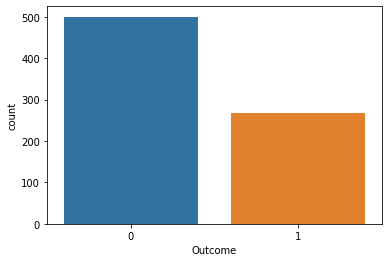

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


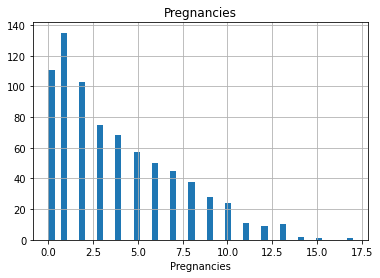

#####################################


count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


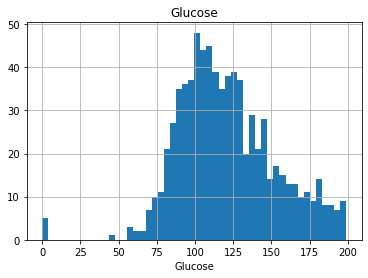

#####################################


count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


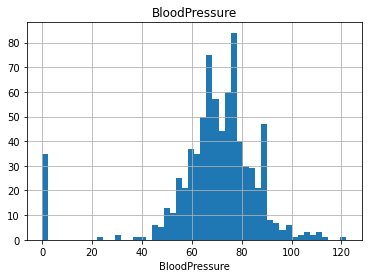

#####################################


count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


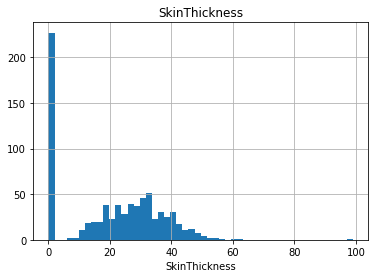

#####################################


count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


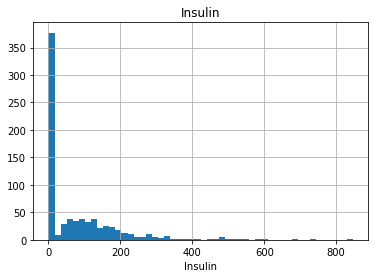

#####################################


count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


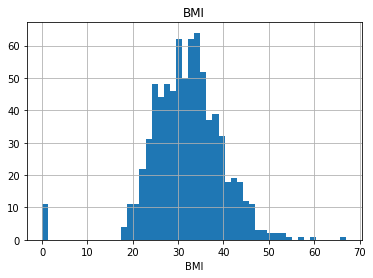

#####################################


count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


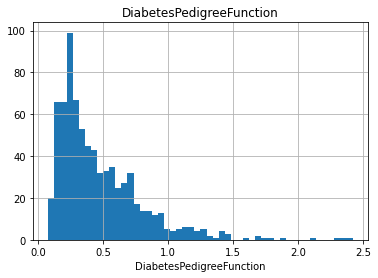

#####################################


count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


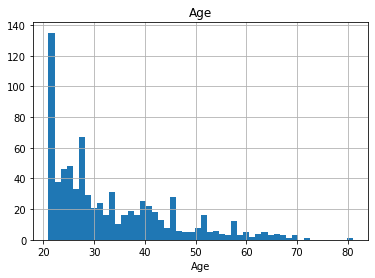

#####################################


         Pregnancies
Outcome             
0              3.298
1              4.866

#################################

         Glucose
Outcome         
0        109.980
1        141.257

#################################

         BloodPressure
Outcome               
0               68.184
1               70.825

#################################

         SkinThickness
Outcome               
0               19.664
1               22.164

#################################

         Insulin
Outcome         
0         68.792
1        100.336

#################################

           BMI
Outcome       
0       30.304
1       35.143

#################################

         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550

#################################

           Age
Outcome       
0       31.190
1       37.067

#################################

############

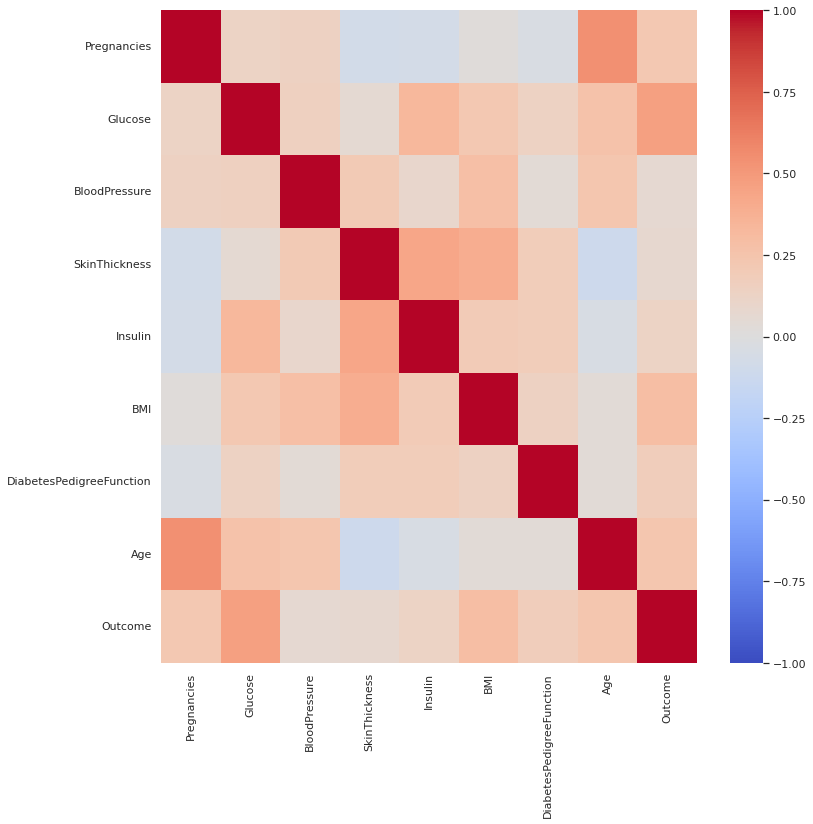

In [5]:
diabet_eda(df, "Outcome")

## Base Modeling

In [6]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       150
           1       0.71      0.59      0.64        81

    accuracy                           0.77       231
   macro avg       0.75      0.73      0.74       231
weighted avg       0.77      0.77      0.77       231

Auc: 0.75


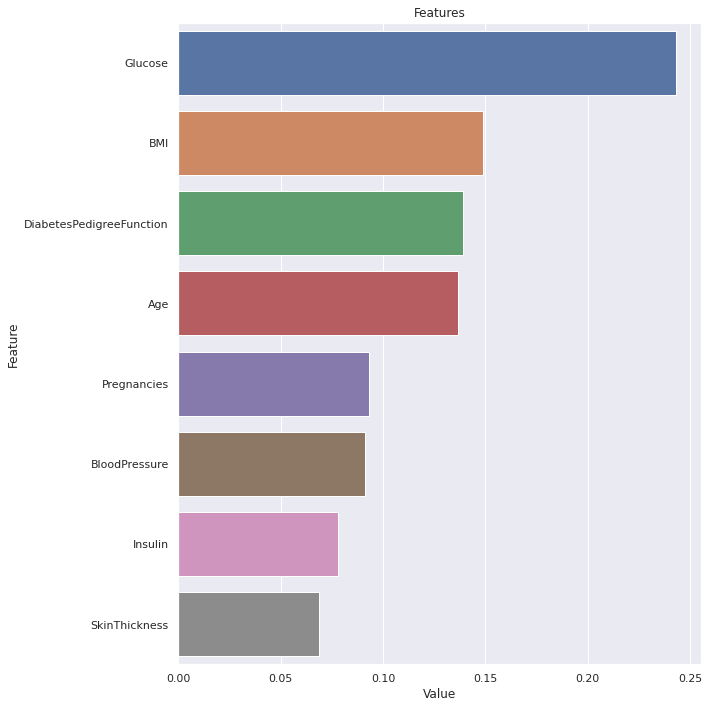

In [7]:
plot_importance(rf_model, X_train)

## Feature Engineering

In [8]:
def diabet_feature_engineering(data):
    
#     Values other than "Outcome" and "Pragnancies" cannot be 0
    data = assing_missing_values(data, except_cols=['Outcome', 'Pregnancies'])
    
#     Filling in missing data with KNN
#     Scale for KNN
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
#     Implementation of knn
    imputer = KNNImputer(n_neighbors=5)
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    data = pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)
    
    print("############### Before Feature Engineering ###############")
    cat_cols, num_cols, cat_but_car = grab_col_names(data)
    
#     Re-assignment with thresholds
    for col in num_cols:
        replace_with_thresholds(data, col)
        
#     New Features
    data["PregnanciesRatio"] = data["Pregnancies"] / data["Age"]
    data["BMIRatio"] = data["BMI"] / data["Age"]
    data["SkinThicknessRatio"] = data["SkinThickness"] / data["Age"]
    data["BloodPressure_BMI_Ratio"] = data["BloodPressure"] / data["BMI"]
    data["BloodPressure_GLucose_Ratio"] = data["BloodPressure"] / data["Glucose"]
    data["New_Glucose*Insulin"] = data["Glucose"] * data["Insulin"]
    data["New_Glucose*Pregnancies"] = data["Glucose"] * data["Pregnancies"]
    
    data["bmi_desc"] = set_bmi(data)
    
    data = data.assign(Insulin_desc=data.apply(set_insulin, axis=1))
    
    print("############### After Feature Engineering ###############")
    cat_cols, num_cols, cat_but_car = grab_col_names(data)
    
#     Label Encoding
    binary_cols = [col for col in data.columns if data[col].dtype not in [int, float] and data[col].nunique() == 2]

    for col in binary_cols:
        data = label_encoder(data, col)
    
#     One-Hot Encoding
    ohe_cols = [col for col in data.columns if 10 >= data[col].nunique() > 2]

    data = one_hot_encoder(data, ohe_cols, True)
    
#     Scaling
    rs = RobustScaler()
    data[num_cols] = rs.fit_transform(data[num_cols])
    
    return data

In [9]:
df = diabet_feature_engineering(df)
df

############### Before Feature Engineering ###############
Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
############### After Feature Engineering ###############
Observations: 768
Variables: 18
cat_cols: 3
num_cols: 15
cat_but_car: 0
num_but_cat: 1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,PregnanciesRatio,BMIRatio,SkinThicknessRatio,BloodPressure_BMI_Ratio,BloodPressure_GLucose_Ratio,New_Glucose*Insulin,New_Glucose*Pregnancies,Insulin_desc,bmi_desc_Morbid Obese,bmi_desc_Obese,bmi_desc_Over,bmi_desc_Under
0,0.600,0.738,0.000,0.498,2.050,0.158,0.665,1.235,1.000,0.198,-0.718,-0.344,-0.169,-0.599,2.008,0.896,0,0,1,0,0
1,-0.400,-0.762,-0.375,0.000,-0.741,-0.603,-0.056,0.118,0.000,-0.504,-0.355,0.102,0.332,0.818,-0.643,-0.416,1,0,0,1,0
2,1.000,1.571,-0.500,0.266,1.084,-0.962,0.783,0.176,1.000,1.238,-0.608,0.235,0.725,-1.266,1.658,1.837,0,0,0,0,0
3,-0.400,-0.667,-0.375,-0.498,-0.361,-0.440,-0.537,-0.471,0.000,-0.381,0.581,0.404,0.136,0.647,-0.430,-0.409,1,0,0,1,0
4,-0.600,0.476,-2.000,0.498,0.382,1.190,5.008,0.235,1.000,-0.762,0.519,0.338,-1.966,-1.548,0.439,-0.555,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.400,-0.381,0.250,1.577,0.502,0.082,-0.527,2.000,0.000,0.508,-1.010,-0.227,0.079,0.701,0.152,1.095,0,0,1,0,0
764,-0.200,0.119,-0.125,-0.166,0.201,0.505,-0.085,-0.118,0.000,-0.169,0.630,0.224,-0.525,-0.172,0.159,-0.156,1,0,1,0,0
765,0.400,0.095,0.000,-0.498,-0.181,-0.647,-0.333,0.059,0.000,0.571,-0.325,-0.218,0.727,-0.068,-0.122,0.434,1,0,0,1,0
766,-0.400,0.214,-0.750,-0.216,-0.076,-0.223,-0.061,1.059,1.000,-0.592,-0.779,-0.606,-0.390,-0.649,-0.011,-0.349,1,0,1,0,0


## Final Modeling

In [10]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(classification_report(y_test, y_pred))
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       150
         1.0       0.75      0.64      0.69        81

    accuracy                           0.80       231
   macro avg       0.79      0.76      0.77       231
weighted avg       0.80      0.80      0.80       231

Auc: 0.79


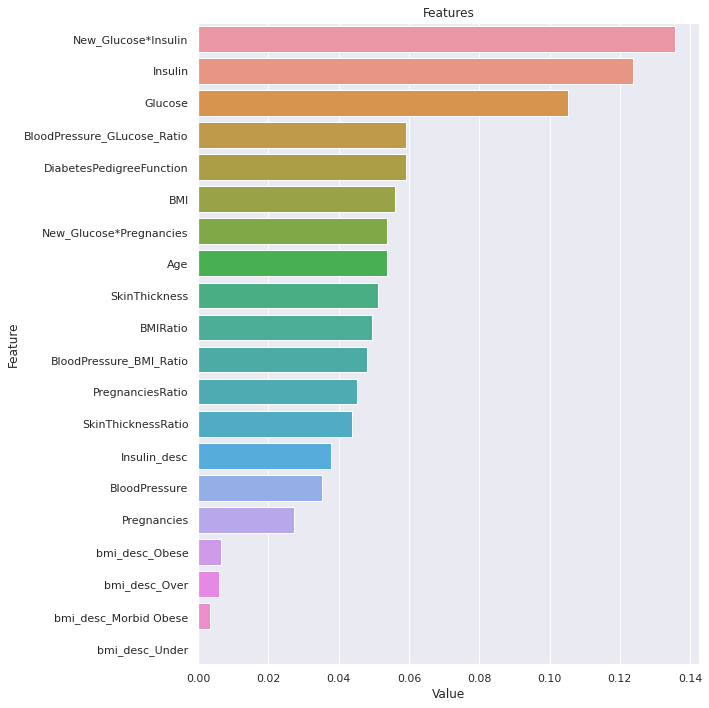

In [11]:
plot_importance(rf_model, X_train)

In [12]:
# Base Model
#               precision    recall  f1-score   support

#            0       0.80      0.87      0.83       150
#            1       0.71      0.59      0.64        81

#     accuracy                           0.77       231
#    macro avg       0.75      0.73      0.74       231
# weighted avg       0.77      0.77      0.77       231

# Auc: 0.75

# Final Model

#               precision    recall  f1-score   support

#          0.0       0.82      0.89      0.85       150
#          1.0       0.75      0.64      0.69        81

#     accuracy                           0.80       231
#    macro avg       0.79      0.76      0.77       231
# weighted avg       0.80      0.80      0.80       231

# Auc: 0.79